In [1]:
from PPO_Agent import PPOAgent
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import cookiedisaster

In [2]:
env_names = ['cookiedisaster-v1', 'cookiedisaster-v2', 'cookiedisaster-v3']
num_iterations = 100
num_steps = 2000

kwargs = {
    'lr': 0.0003,
    'gamma': 0.99,
    'clip': 0.2,
    'epochs': 10,
    'batch_size': 64
}

agent = PPOAgent()
agent.learn(env_names, num_iterations, num_steps, **kwargs)

c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\augus\AppData\Local\Programs

Iteration: 1 / 100, Reward: -48.61103693029386
Iteration: 2 / 100, Reward: -79.71252642884434
Iteration: 3 / 100, Reward: -60.6751623225459
Iteration: 4 / 100, Reward: -3.95956950327526
Iteration: 5 / 100, Reward: -0.8170028723952063
Iteration: 6 / 100, Reward: 6.9409696757742925
Iteration: 7 / 100, Reward: 18.37788775307356
Iteration: 8 / 100, Reward: 22.931778769402186
Iteration: 9 / 100, Reward: 13.445058271029414
Iteration: 10 / 100, Reward: 81.8340951059534
Iteration: 11 / 100, Reward: 47.59127296935284
Iteration: 12 / 100, Reward: 61.751744709504266
Iteration: 13 / 100, Reward: 107.43815817878243
Iteration: 14 / 100, Reward: 55.08145987228406
Iteration: 15 / 100, Reward: 60.602454720768655
Iteration: 16 / 100, Reward: 152.94601730834069
Iteration: 17 / 100, Reward: 72.74987499654799
Iteration: 18 / 100, Reward: 89.33272807597999
Iteration: 19 / 100, Reward: 148.94501236665397
Iteration: 20 / 100, Reward: 97.21132641459805
Iteration: 21 / 100, Reward: 91.86347840911567
Iteration: 

In [3]:
agent.save()

In [4]:
def run_continuous_policy(env, agent, friction_coefficient, show_stats=True, num_steps=250):
    observation, _ = env.reset()
    total_reward = 0
    agent_positions, agent_velocities, cookie_positions, cookie_times = [], [], [], []
    cumulative_rewards, times_to_collect_cookies = [0], []
    missed_cookies, hit_walls = [], []

    for step in range(num_steps):
        env.render()
        with torch.no_grad():
            action = agent.select_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            observation, _ = env.reset()
            print(f"Resetting environment at step {step} with Cumulative Reward: {total_reward}")
            total_reward = 0

        cumulative_rewards.append(cumulative_rewards[-1] + reward)
        agent_positions.append(observation["agent"]["pos"])
        agent_velocities.append(observation["agent"]["vel"])
        cookie_positions.append(observation["cookie"]["pos"])
        cookie_times.append(observation["cookie"]["time"])

        if reward > 0:
            times_to_collect_cookies.append(step)

        if (round(agent_positions[-1], 4) == 0 or round(agent_positions[-1], 4) == 1) and reward != 0 and reward < 1:
            hit_walls.append(step)
        elif step > 2 and cookie_positions[-1] != cookie_positions[-2] and reward <= 0.5:
            missed_cookies.append(step)

    env.close()
    if show_stats:
        plot_results(agent_positions, cookie_positions, cumulative_rewards, times_to_collect_cookies, missed_cookies, hit_walls, env.config, friction_coefficient)
        analyze_results(cumulative_rewards, times_to_collect_cookies, missed_cookies, hit_walls)
    
    collected_cookie_ratio = len(times_to_collect_cookies) / (len(times_to_collect_cookies) + len(missed_cookies))
    time_differences = [t2 - t1 for t1, t2 in zip(times_to_collect_cookies[:-1], times_to_collect_cookies[1:])]
    average_time_to_collect = sum(time_differences) / len(time_differences) if time_differences else 0

    return (cumulative_rewards[-1], len(times_to_collect_cookies), len(missed_cookies), collected_cookie_ratio, average_time_to_collect, len(hit_walls))


def plot_results(agent_positions, cookie_positions, cumulative_rewards, times_to_collect_cookies, missed_cookies, hit_walls, config, friction_coefficient):
    
    falling_object = config['img'].title()
    plt.figure(figsize=(12, 10))
    plt.subplot(5, 1, 1)
    plt.plot(agent_positions, label='Agent Position', zorder=2)
    plt.plot(cookie_positions, label=f'{falling_object} Position', zorder=1, linestyle='dashed')
    collected_cookie_y_values = [cookie_positions[time - 1] for time in times_to_collect_cookies]
    missed_cookie_y_values = [cookie_positions[time - 1] for time in missed_cookies]
    hit_walls_y_values = [agent_positions[time - 1] for time in hit_walls]
    plt.scatter(times_to_collect_cookies, collected_cookie_y_values, label='Collected Cookie', zorder=3)
    plt.scatter(missed_cookies, missed_cookie_y_values, color='red', label='Missed Cookie', marker='x', zorder=4)
    plt.scatter(hit_walls, hit_walls_y_values, color='black', label='Hit Wall', marker='x', zorder=5)
    plt.xlabel('Steps')
    plt.ylabel('Position')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f'Agent and {falling_object} Positions Over Time - Width: {config["width"]}, Lifetime: {config["lifetime"]}, Friction Coefficient: {friction_coefficient}')

    plt.subplot(5, 1, 2)
    plt.plot(cumulative_rewards, color='green', label='Cumulative Rewards')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Cumulative Rewards Over Time')
    plt.subplots_adjust(right=0.75)
    plt.tight_layout()
    plt.show()


def analyze_results(cumulative_rewards, times_to_collect_cookies, missed_cookies, hit_walls):
    collected_cookie_ratio = len(times_to_collect_cookies) / (len(times_to_collect_cookies) + len(missed_cookies))
    time_differences = [t2 - t1 for t1, t2 in zip(times_to_collect_cookies[:-1], times_to_collect_cookies[1:])]
    average_time_to_collect = sum(time_differences) / len(time_differences) if time_differences else 0

    print(f"Final cumulative reward: {cumulative_rewards[-1]}")
    print(f"Collected cookies: {len(times_to_collect_cookies)}")
    print(f"Missed cookies: {len(missed_cookies)}")
    print(f"Collected cookie ratio: {collected_cookie_ratio}")
    print(f"Average time to collect a cookie: {average_time_to_collect}")
    print(f"Hit walls: {len(hit_walls)} - steps {hit_walls}")

c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


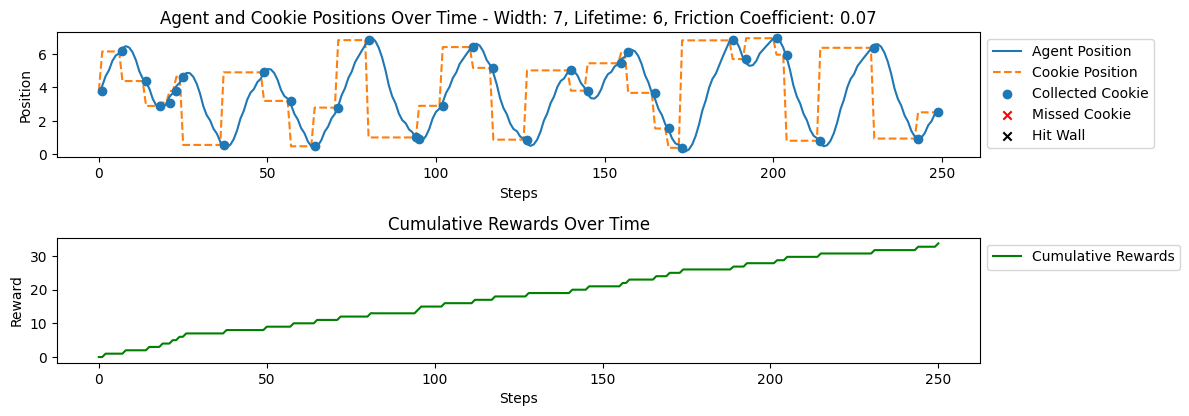

Final cumulative reward: 33.70107106687915
Collected cookies: 34
Missed cookies: 0
Collected cookie ratio: 1.0
Average time to collect a cookie: 7.515151515151516
Hit walls: 0 - steps []


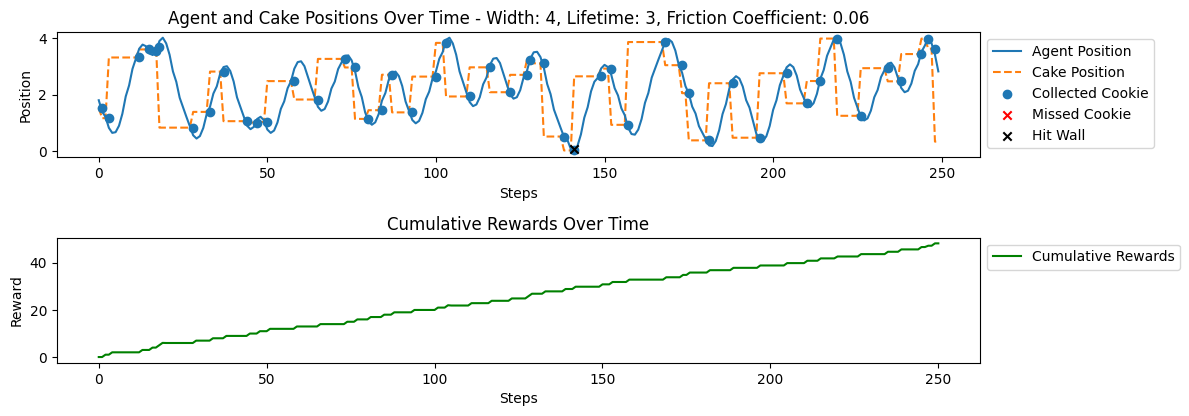

Final cumulative reward: 48.174988498841984
Collected cookies: 49
Missed cookies: 0
Collected cookie ratio: 1.0
Average time to collect a cookie: 5.145833333333333
Hit walls: 1 - steps [141]


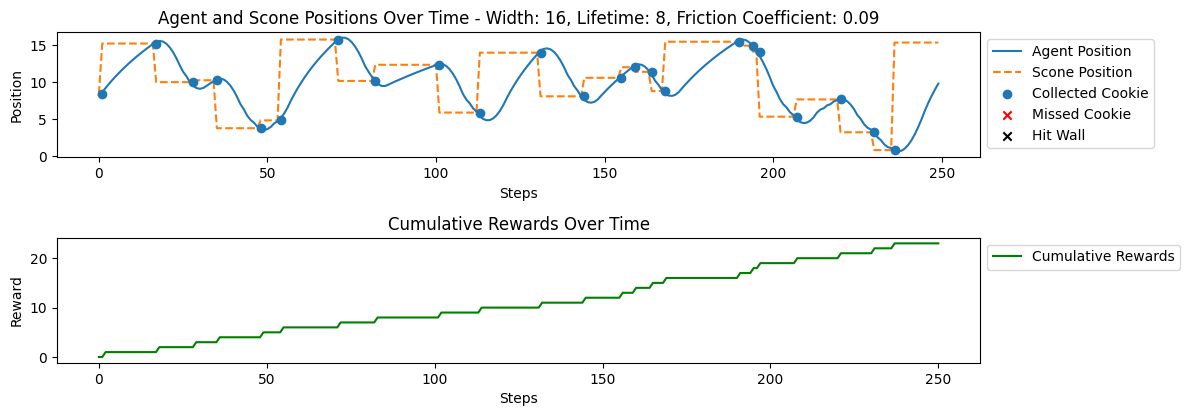

Final cumulative reward: 23
Collected cookies: 23
Missed cookies: 0
Collected cookie ratio: 1.0
Average time to collect a cookie: 10.681818181818182
Hit walls: 0 - steps []


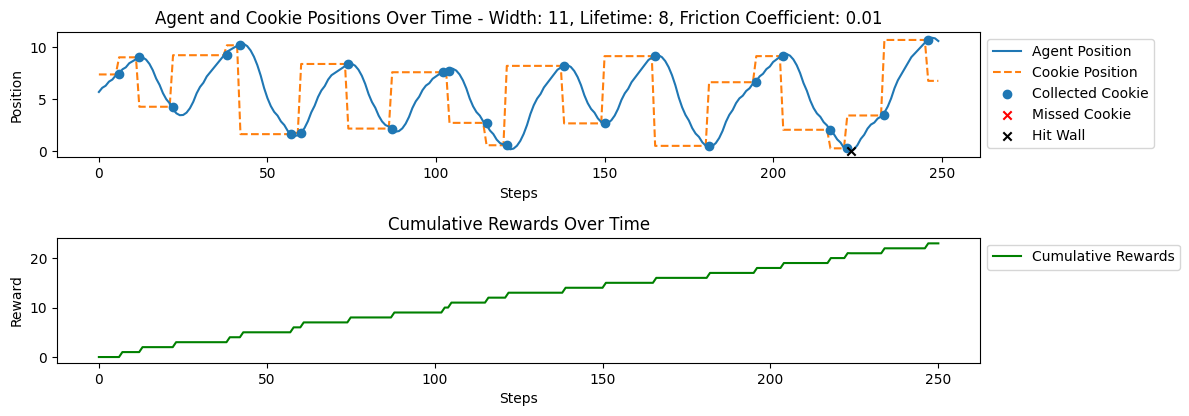

Final cumulative reward: 22.973411501983847
Collected cookies: 23
Missed cookies: 0
Collected cookie ratio: 1.0
Average time to collect a cookie: 10.909090909090908
Hit walls: 1 - steps [223]


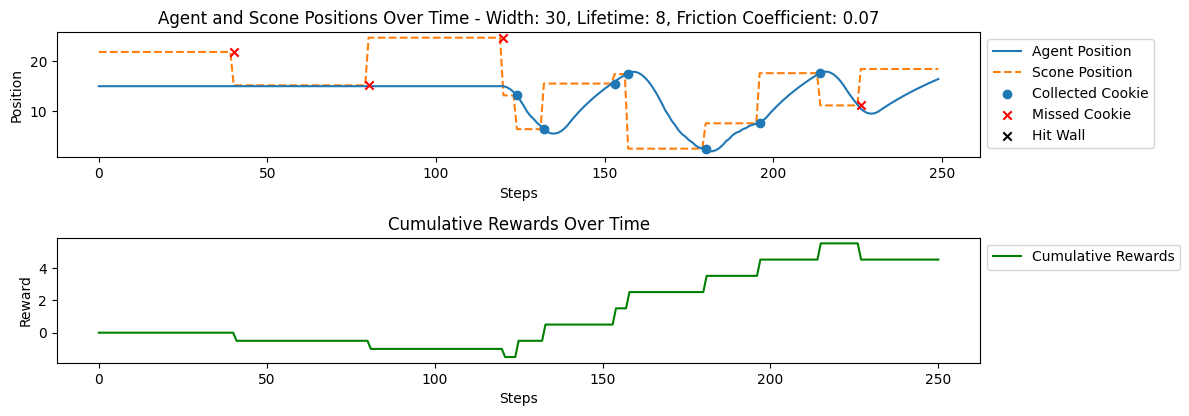

Final cumulative reward: 4.5
Collected cookies: 7
Missed cookies: 4
Collected cookie ratio: 0.6363636363636364
Average time to collect a cookie: 15.0
Hit walls: 0 - steps []


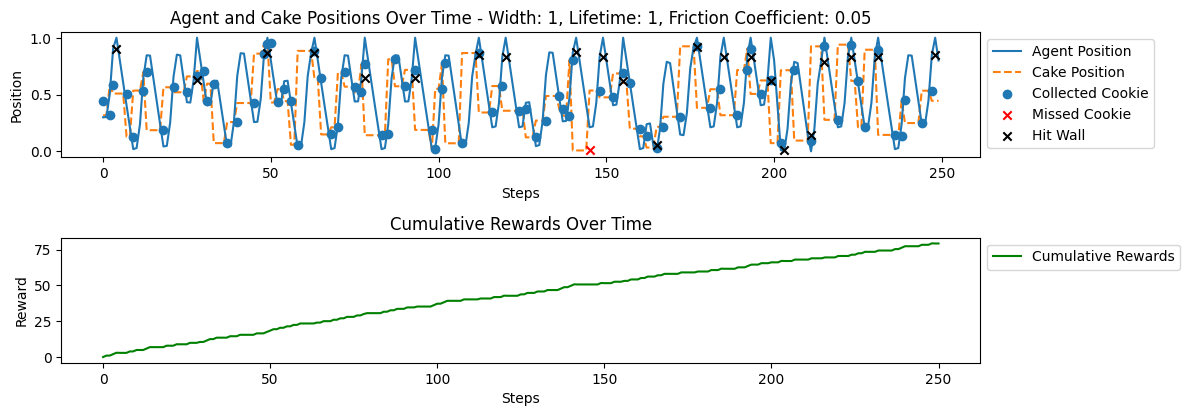

Final cumulative reward: 79.23773963859274
Collected cookies: 84
Missed cookies: 1
Collected cookie ratio: 0.9882352941176471
Average time to collect a cookie: 2.9759036144578315
Hit walls: 22 - steps [4, 28, 49, 63, 78, 93, 112, 120, 141, 149, 155, 165, 177, 185, 193, 199, 203, 211, 215, 223, 231, 248]


(79.23773963859274, 84, 1, 0.9882352941176471, 2.9759036144578315, 22)

In [5]:
env = gym.make('cookiedisaster-new-1')
run_continuous_policy(env, agent, 0.07)

env = gym.make('cookiedisaster-new-2')
run_continuous_policy(env, agent, 0.06)

env = gym.make('cookiedisaster-new-3')
run_continuous_policy(env, agent, 0.09)

env = gym.make('cookiedisaster-new-4')
run_continuous_policy(env, agent, 0.01)

env = gym.make('cookiedisaster-new-5')
run_continuous_policy(env, agent, 0.07)

env = gym.make('cookiedisaster-new-6')
run_continuous_policy(env, agent, 0.05)

In [6]:
record = []
episodes = 1000

# Run the policy in the environment
for episode in range(episodes):
    if episode % 100 == 0:
        print(f"Running episode {episode + 1} / {episodes}")
    env = gym.make('cookiedisaster-v1')
    results = run_continuous_policy(env, agent, 0.05, show_stats=False)
    record.append(results)

average_cumulative_reward = sum(result[0] for result in record) / len(record)
average_collected_cookies = sum(result[1] for result in record) / len(record)
average_missed_cookies = sum(result[2] for result in record) / len(record)
average_collected_cookie_ratio = sum(result[3] for result in record) / len(record)
average_time_to_collect = sum(result[4] for result in record) / len(record)
average_number_of_hit_walls = sum(result[5] for result in record) / len(record)

print()
print(f"Average Cumulative Reward: {average_cumulative_reward}")
print(f"Average Collected Cookies: {average_collected_cookies}")
print(f"Average Missed Cookies: {average_missed_cookies}")
print(f"Average Collected Cookie Ratio: {average_collected_cookie_ratio}")
print(f"Average Time to Collect a Cookie: {average_time_to_collect}")
print(f"Average Number of Hit Walls: {average_number_of_hit_walls}")

Running episode 1 / 1000


c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


Running episode 101 / 1000
Running episode 201 / 1000
Running episode 301 / 1000
Running episode 401 / 1000
Running episode 501 / 1000
Running episode 601 / 1000
Running episode 701 / 1000
Running episode 801 / 1000
Running episode 901 / 1000

Average Cumulative Reward: 27.081727000115464
Average Collected Cookies: 27.702
Average Missed Cookies: 0.47
Average Collected Cookie Ratio: 0.9832085155220975
Average Time to Collect a Cookie: 9.016418859634111
Average Number of Hit Walls: 0.621


In [11]:
agent_2 = PPOAgent()
agent_2.load()

In [12]:
env = gym.make('cookiedisaster-new-2', render_mode='human')
observation, info = env.reset(seed=0)

for _ in range(100):
   action = agent_2.select_action(observation)
   observation, reward, terminated, truncated, info = env.step(action)
   if terminated or truncated:
      observation, info = env.reset()
env.close()

In [13]:
agent_2.learn(env_names, 10, num_steps, **kwargs)

c:\Users\augus\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


Iteration: 1 / 10, Reward: 280.9518842383689
Iteration: 2 / 10, Reward: 187.31143393303742
Iteration: 3 / 10, Reward: 211.8694315982215
Iteration: 4 / 10, Reward: 294.4774818249729
Iteration: 5 / 10, Reward: 191.41561158028688
Iteration: 6 / 10, Reward: 209.7282878484864
Iteration: 7 / 10, Reward: 296.7048077695613
Iteration: 8 / 10, Reward: 180.90014681131902
Iteration: 9 / 10, Reward: 217.41418400271982
Iteration: 10 / 10, Reward: 272.9507485136336


In [14]:
env = gym.make('cookiedisaster-new-3', render_mode='human')
observation, info = env.reset(seed=0)

for _ in range(100):
   action = agent_2.select_action(observation)
   observation, reward, terminated, truncated, info = env.step(action)
   if terminated or truncated:
      observation, info = env.reset()
env.close()